Currently, there are numerous approaches to cancer research. Some aim to reduce its effects, others focus on curing it entirely, and still others work toward prevention. This variety of strategies exists because cancer has remained a major enigma for decades. Even today, we do not fully understand how to respond to it. While we can estimate probabilities for instance, using survival statistics, even in the most favorable scenarios, these predictions can be wrong. As mentioned, cancer is a profound mystery.

There are many pharmaceutical companies involved in this field, and a wide range of drugs have been developed to help patients improve their condition. However, these drugs do not affect all individuals in the same way. This study aims to explore that particular aspect of the enigma: we seek to estimate drug effectiveness based on the patient’s genomic information.

In this study, we utilize the [Genomics of Drug Sensitivity in Cancer (GDSC) dataset](https://www.kaggle.com/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc). Our workflow is structured as follows:

1. We will analyze the data provided in the dataset.
2. We will explore various methods to uncover the relationship between genomic features and drug response.
3. We will develop multiple predictive models aimed at estimating drug effectiveness.
4. Once the optimal model is identified, we will apply explainable artificial intelligence (XAI) techniques to understand which genomic features influence drug efficacy.

If we can determine how genomic information affects drug response, it could lead to more personalized and effective strategies for cancer treatment.

The information used in this study is provided by the [COSMIC database](https://cancer.sanger.ac.uk/cosmic), one of the most important repositories of somatic mutations in cancer. This resource offers a wide range of data, including cell line information, cancer-related statistics, and details on mutations that occur during cancer development.

In our case, the target variable is LNIC_50, which represents the logarithmic concentration of a drug required to achieve a measurable effect on cancer cells:

- A lower LNIC_50 value indicates that less of the drug is needed to produce an effect, meaning the cancer is more sensitive to the treatment, which is a favorable outcome.
- Conversely, a higher LNIC_50 implies that a higher drug concentration is necessary, suggesting that the cancer cells are less responsive or more resistant to the drug.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import datetime


In [3]:
import tensorflow as tf
#from tensorflow.keras import layers
#from tensorflow.keras import Model
#from tensorflow.keras import optimizers

#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras import callbacks

In [4]:
from keras import models
from keras import layers, Input

In [5]:
import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Load data

In [6]:
# Load the datasets
gdsc_dataset = pd.read_csv('./data/GDSC_DATASET.csv')
compounds_annotation = pd.read_csv('./data/Compounds-annotation.csv')
gdsc2_dataset = pd.read_csv('./data/GDSC2-dataset.csv')
#cell_lines_details = pd.read_excel('./data/Cell_Lines_Details.xlsx')
cell_lines_details = pd.read_csv('./data/Cell_Lines_Details.csv')

1. GDSC2-dataset.csv:
* **DATASET**: Identifier for the specific GDSC dataset version.
* **NLME_RESULT_ID**: Unique identifier for the non-linear mixed effects model result.
* **NLME_CURVE_ID**: Identifier for the dose-response curve fitted by NLME.
* **COSMIC_ID**: Unique identifier for the cell line from the COSMIC database.
* **CELL_LINE_NAME**: Name of the cancer cell line used in the experiment.
* **SANGER_MODEL_ID**: Identifier used by the Sanger Institute for the cell line model.
* **TCGA_DESC**: Description of the cancer type according to The Cancer Genome Atlas.
* **DRUG_ID**: Unique identifier for the drug used in the experiment.
* **DRUG_NAME**: Name of the drug used in the experiment.
* **PUTATIVE_TARGET**: The presumed molecular target of the drug. 
* **PATHWAY_NAME**: The biological pathway affected by the drug. 
* **COMPANY_ID**: Identifier for the company that provided the drug.
* **WEBRELEASE**: Date or version of web release for this data.
* **MIN_CONC**: Minimum concentration of the drug used in the experiment.
* **MAX_CONC**: Maximum concentration of the drug used in the experiment.
* **LN_IC50**: Natural log of the half-maximal inhibitory concentration (IC50).
* **AUC**: Area Under the Curve, a measure of drug effectiveness.
* **RMSE**: Root Mean Square Error, indicating the fit quality of the dose-response curve.
* **Z_SCORE**: Standardized score of the drug response, allowing comparison across different drugs and cell lines.

2. Cell_Lines_Details.xlsx:
* **Sample Name**: Unique identifier for the cell line sample.
* **COSMIC identifier**: Unique ID from the COSMIC database for the cell line.
* **Whole Exome Sequencing (WES)**: Genetic mutation data from whole exome sequencing. 
* **Copy Number Alterations (CNA)**: Data on gene copy number changes in the cell line.
* **Gene Expression**: Information on gene expression levels in the cell line.
* **Methylation**: Data on DNA methylation patterns in the cell line.
* **Drug Response**: Information on how the cell line responds to various drugs.
* **GDSC Tissue descriptor 1**: Primary tissue type classification.
* **GDSC Tissue descriptor 2**: Secondary tissue type classification.
* **Cancer Type (matching TCGA label)**: Cancer type according to TCGA classification.
* **Microsatellite instability Status (MSI)**: Indicates the cell line's MSI status.
* **Screen Medium**: The growth medium used for culturing the cell line.
* **Growth Properties**: Characteristics of how the cell line grows in culture.

3. Compounds-annotation.csv:
* **DRUG_ID**: Unique identifier for the drug.
* **SCREENING_SITE**: Location where the drug screening was performed.
* **DRUG_NAME**: Name of the drug compound.
* **SYNONYMS**: Alternative names for the drug.
* **TARGET**: The molecular target(s) of the drug.
* **TARGET_PATHWAY**: The biological pathway(s) targeted by the drug.

4. gdsc_dataset.csv: It is the dataset dedicated to analisis.



### Exploring data

In [7]:
# Display the first few rows of each dataset
display(gdsc_dataset.head())
display(compounds_annotation.head())
display(gdsc2_dataset.head())
display(cell_lines_details.head())

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-5.044940,0.592660,-1.516647,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.741991,0.734047,-0.807232,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-5.142961,0.582439,-1.570016,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


,DRUG_ID,SCREENING_SITE,DRUG_NAME,SYNONYMS,TARGET,TARGET_PATHWAY
0,1,MGH,Erlotinib,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",EGFR,EGFR signaling
1,3,MGH,Rapamycin,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",MTORC1,PI3K/MTOR signaling
2,5,MGH,Sunitinib,"Sutent, Sunitinib Malate, SU-11248","PDGFR, KIT, VEGFR, FLT3, RET, CSF1R",RTK signaling
3,6,MGH,PHA-665752,"PHA665752, PHA 665752",MET,RTK signaling
4,9,MGH,MG-132,"LLL cpd, MG 132, MG132","Proteasome, CAPN1",Protein stability and degradation


,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,343,15946310,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-1.463887,0.930220,0.089052,0.433123
1,GDSC2,343,15946548,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-4.869455,0.614970,0.111351,-1.421100
2,GDSC2,343,15946830,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.360586,0.791072,0.142855,-0.599569
3,GDSC2,343,15947087,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-5.044940,0.592660,0.135539,-1.516647
4,GDSC2,343,15947369,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.741991,0.734047,0.128059,-0.807232


,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug Response,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties
0,A253,906794.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


Before merging the different CSV files, it is necessary to identify the columns they have in common.

In [8]:
print("Common columns (gdsc_dataset) (cell_lines_details):", gdsc_dataset.columns.intersection(cell_lines_details.columns).values)
print("Common columns (gdsc2_dataset) (cell_lines_details):", gdsc2_dataset.columns.intersection(cell_lines_details.columns).values)


Common columns (gdsc_dataset) (cell_lines_details): ['GDSC Tissue descriptor 1' 'GDSC Tissue descriptor 2'
 'Cancer Type (matching TCGA label)'
 'Microsatellite instability Status (MSI)' 'Screen Medium'
 'Growth Properties' 'Gene Expression' 'Methylation']
Common columns (gdsc2_dataset) (cell_lines_details): []


In [9]:
for col in gdsc_dataset.columns:
    if col.upper() != ("cosmic_id".upper()):
        content = gdsc_dataset[col].unique()
        suffix = "..." if len(content) > 10 else ""
        print(f"\033[1m* {col}\033[0m -> {content[:10]} {suffix}")



* CELL_LINE_NAME -> ['PFSK-1' 'ES5' 'ES7' 'EW-11' 'SK-ES-1' 'COLO-829' '5637' 'RT4' 'SW780'
 'TCCSUP'] ...
* TCGA_DESC -> ['MB' 'UNCLASSIFIED' 'SKCM' 'BLCA' 'CESC' 'GBM' 'LUAD' 'LUSC' 'SCLC'
 'MESO'] ...
* DRUG_ID -> [1003 1004 1005 1006 1007 1008 1009 1010 1011 1012] ...
* DRUG_NAME -> ['Camptothecin' 'Vinblastine' 'Cisplatin' 'Cytarabine' 'Docetaxel'
 'Methotrexate' 'Tretinoin' 'Gefitinib' 'Navitoclax' 'Vorinostat'] ...
* LN_IC50 -> [-1.463887 -3.360586 -5.04494  -3.741991 -5.142961 -1.235034 -2.632632
 -2.963191 -1.449138 -2.350633] ...
* AUC -> [0.93022  0.791072 0.59266  0.734047 0.582439 0.867348 0.834067 0.821438
 0.90505  0.84343 ] ...
* Z_SCORE -> [ 0.433123 -0.599569 -1.516647 -0.807232 -1.570016  0.557727 -0.203221
 -0.3832    0.441154 -0.049682] ...
* GDSC Tissue descriptor 1 -> ['nervous_system' 'bone' 'skin' nan 'urogenital_system' 'lung_NSCLC'
 'lung_SCLC' 'lung' 'neuroblastoma' 'soft_tissue'] ...
* GDSC Tissue descriptor 2 -> ['medulloblastoma' 'ewings_sarcoma' 'melanom

In [10]:
print(gdsc_dataset.shape)

(242035, 19)


In [11]:
# Check for missing values
print(gdsc_dataset.isnull().sum())
print(compounds_annotation.isnull().sum())
print(gdsc2_dataset.isnull().sum())
print(cell_lines_details.isnull().sum())

COSMIC_ID                                      0
CELL_LINE_NAME                                 0
TCGA_DESC                                   1067
DRUG_ID                                        0
DRUG_NAME                                      0
LN_IC50                                        0
AUC                                            0
Z_SCORE                                        0
GDSC Tissue descriptor 1                    9366
GDSC Tissue descriptor 2                    9366
Cancer Type (matching TCGA label)          51446
Microsatellite instability Status (MSI)    12353
Screen Medium                               9366
Growth Properties                           9366
CNA                                         9366
Gene Expression                             9366
Methylation                                 9366
TARGET                                     27155
TARGET_PATHWAY                                 0
dtype: int64
DRUG_ID             0
SCREENING_SITE      0
DRUG_NAME   

In [12]:
# Drop rows with missing values for simplicity

gdsc_dataset = gdsc_dataset.dropna()
compounds_annotation = compounds_annotation.dropna()
gdsc2_dataset = gdsc2_dataset.dropna()
cell_lines_details = cell_lines_details.dropna()

dataset = gdsc_dataset.copy()

In [13]:
# Merge GDSC2 dataset with Cell Lines Details on COSMIC_ID
merged_df = pd.merge(gdsc2_dataset, cell_lines_details, left_on='COSMIC_ID', right_on='COSMIC identifier', how='left')

# Merge the resulting dataframe with Compounds Annotation on DRUG_ID
final_df = pd.merge(merged_df, compounds_annotation, on='DRUG_ID', how='left')

We check if dataset use "?" to refere some unknow value.

In [14]:
print((final_df == "?").any().any())

False


In [15]:
dataset = final_df.drop(columns=["DATASET"])

This dataset contains some categorical columns, which we need to replace with numerical values because machine learning algorithms require numerical input.

We have 2 alternatives, [`one-hot encding`](https://www.geeksforgeeks.org/ml-one-hot-encoding/) or [`label encoding`](https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/).

- `One-hot encoding`: This method replaces each possible category with a new column, where a value of 1 indicates the presence of that category.
- `Label encoding`: This approach replaces categorical values with numerical ones. It can be useful when the assigned numbers represent meaningful relationships between the categories.


In [16]:
print(dataset.select_dtypes(exclude=["number"]).columns)
print(dataset.shape)

Index(['CELL_LINE_NAME', 'SANGER_MODEL_ID', 'TCGA_DESC', 'DRUG_NAME_x',
       'PUTATIVE_TARGET', 'PATHWAY_NAME', 'WEBRELEASE', 'Sample Name',
       'Whole Exome Sequencing (WES)', 'Copy Number Alterations (CNA)',
       'Gene Expression', 'Methylation', 'Drug Response',
       'GDSC Tissue descriptor 1', 'GDSC Tissue descriptor 2',
       'Cancer Type (matching TCGA label)',
       'Microsatellite instability Status (MSI)', 'Screen Medium',
       'Growth Properties', 'SCREENING_SITE', 'DRUG_NAME_y', 'SYNONYMS',
       'TARGET', 'TARGET_PATHWAY'],
      dtype='object')
(213825, 36)


If we examine the columns DRUG_NAME_x and DRUG_NAME_y, we can see that DRUG_NAME_x is equal to DRUG_NAME_y, except in some cases where DRUG_NAME_y differs, likely due to human error. Therefore, we have decided to delete the DRUG_NAME_y column.

Similarly, the SCREENING_SITE column contains only one value, "SANGER", or NaN, so we remove this column as well. The same applies to WEBRELEASE, where the only observed value is "Y".

Additionally, we remove columns that contain drug names or target information.

In [17]:
non_matching = dataset[~(dataset['DRUG_NAME_x'] == dataset['DRUG_NAME_y'])]
print(non_matching["DRUG_NAME_x"].unique())
print(non_matching["DRUG_NAME_y"].unique())
dataset = dataset.drop(columns=["DRUG_NAME_y", "SCREENING_SITE", "WEBRELEASE", "PUTATIVE_TARGET", "PATHWAY_NAME", "Sample Name", "CELL_LINE_NAME", "SANGER_MODEL_ID", "SYNONYMS", "TARGET", "TARGET_PATHWAY"])

['Staurosporine' 'JNK Inhibitor VIII' 'Nutlin-3a (-)' 'Mirin' 'RO-3306'
 'CCT007093' 'BI-2536' 'BMS-345541' 'Bleomycin (50 uM)' 'LCL161'
 'BDF00022089a' 'GSK2256098C' 'GSK2276186C' 'GSK2110183B' 'GSK626616AC'
 'GSK3337463A' 'GSK2830371A' 'LMB_AB1' 'LMB_AB2' 'LMB_AB3' 'Oxaliplatin'
 'Topotecan' 'Mitoxantrone' 'Bleomycin' 'Fulvestrant' 'OF-1' 'MN-64'
 'BDP-00009066' 'ABT737' 'AZD3759' 'AZD5363' 'ICL-SIRT078' 'GSK343'
 'UNC0638' 'AGK2' 'BIBR-1532' 'Pyridostatin' 'LJI308' 'AZ6102' 'CT7033-2'
 'GSK-LSD1-2HCl ' '5-azacytidine' 'A-366' 'CPI-637' 'UNC0379' 'AT13148'
 'PFI-1' 'SGC0946' 'GSK2830371']
[nan]


We replace the values in the Methylation, Drug Response, Gene Expression and Copy Number Alterations (CNA) columns as follows:

- `N` is replaced with -1
- `Y` is replaced with 1
- `NaN` is replaced with 0

In [18]:
yes_no_map = {"N": -1, np.nan: 0, "Y": 1}
dataset["Methylation"] = dataset["Methylation"].map(yes_no_map)
dataset["Drug Response"] = dataset["Drug Response"].map(yes_no_map)
dataset["Copy Number Alterations (CNA)"] = dataset["Copy Number Alterations (CNA)"].map(yes_no_map)  
dataset["Gene Expression"] = dataset["Gene Expression"].map(yes_no_map)

The `Whole Exome Sequencing (WES)` column contains only 'y' or NaN (due to the merge), so we will apply the yes_no_map as well.

In [19]:
dataset["Whole Exome Sequencing (WES)"] = dataset["Whole Exome Sequencing (WES)"].map(yes_no_map)

The Growth Properties column represents adherence, so we can replace the categorical values with numeric ones. Since the correct assignment of NaN values is unknown, we decided to replace NaN with 1 and suspension with 0, as these values could be either 0 or greater.

In [20]:
adhenrence_map = {"Adherent": 3, np.nan: 1, "Semi-Adherent": 2, "Suspension": 0}
dataset["Growth Properties"] = dataset["Growth Properties"].map(adhenrence_map)

In [21]:
print("\033[1m* Non numerics\033[0m", dataset.select_dtypes(exclude=["number"]).columns)
print("\033[1m* Numerics\033[0m", dataset.select_dtypes(include=["number"]).columns)
print(dataset.shape)

* Non numerics Index(['TCGA_DESC', 'DRUG_NAME_x', 'GDSC Tissue descriptor 1',
       'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
       'Microsatellite instability Status (MSI)', 'Screen Medium'],
      dtype='object')
* Numerics Index(['NLME_RESULT_ID', 'NLME_CURVE_ID', 'COSMIC_ID', 'DRUG_ID', 'COMPANY_ID',
       'MIN_CONC', 'MAX_CONC', 'LN_IC50', 'AUC', 'RMSE', 'Z_SCORE',
       'COSMIC identifier', 'Whole Exome Sequencing (WES)',
       'Copy Number Alterations (CNA)', 'Gene Expression', 'Methylation',
       'Drug Response', 'Growth Properties'],
      dtype='object')
(213825, 25)


We delete some IDs that are no longer important from this point onward, as all the data has already been merged.

In [22]:
dataset = dataset.drop(columns=["COSMIC_ID", "NLME_RESULT_ID", "NLME_CURVE_ID", "COMPANY_ID", "COSMIC identifier"])

Now, we can check if DRUG_ID and DRUG_NAME_x are consistences.

In [23]:
def check_id_name_consistency(df, id_col="DRUG_ID", name_col="DRUG_NAME_x"):
    names = df[name_col].unique()
    ids_values = df[name_col].unique()
    names_inconsistences = []
    ids_inconsistences = []
    for i in names:
        ids = df[df[name_col] == i][id_col].unique()
        if len(ids) > 1:
            print(f"names' inconsistencies: {i}")
            names_inconsistences.append(i)
    for i in ids_values:
        names = df[df[id_col] == i][name_col].unique()
        if len(names) > 1:
            print(f"ids' inconsistencies: {i}")
            ids_inconsistences.append(i)
    if len(names_inconsistences) > 0:
        print(f"There are inconsistencies in names: {names_inconsistences}")
    if len(ids_inconsistences) > 0:
        print(f"There are inconsistencies in ids: {ids_inconsistences}")
        
is_consistent = check_id_name_consistency(dataset)


names' inconsistencies: Docetaxel
names' inconsistencies: Selumetinib
names' inconsistencies: Oxaliplatin
names' inconsistencies: Fulvestrant
names' inconsistencies: Uprosertib
names' inconsistencies: GSK343
names' inconsistencies: Dactinomycin
names' inconsistencies: Ulixertinib
There are inconsistencies in names: ['Docetaxel', 'Selumetinib', 'Oxaliplatin', 'Fulvestrant', 'Uprosertib', 'GSK343', 'Dactinomycin', 'Ulixertinib']


We detected some inconsistencies between names and IDs. There are some names associated with more than one ID. Therefore, we can delete the DRUG_ID column since no DRUG_ID refers to more than one DRUG_NAME_x.

In [24]:
X = dataset.drop(columns=["DRUG_ID"])

Temporarily, we replace the remaining categorical values using a random label encoder. This approach allows us to examine the correlation matrix.

In [25]:
encoder = LabelEncoder()
dataset_corr = dataset.copy()
for col in dataset_corr.select_dtypes(exclude=["number"]).columns:
    dataset_corr[col] = encoder.fit_transform(dataset_corr[col])

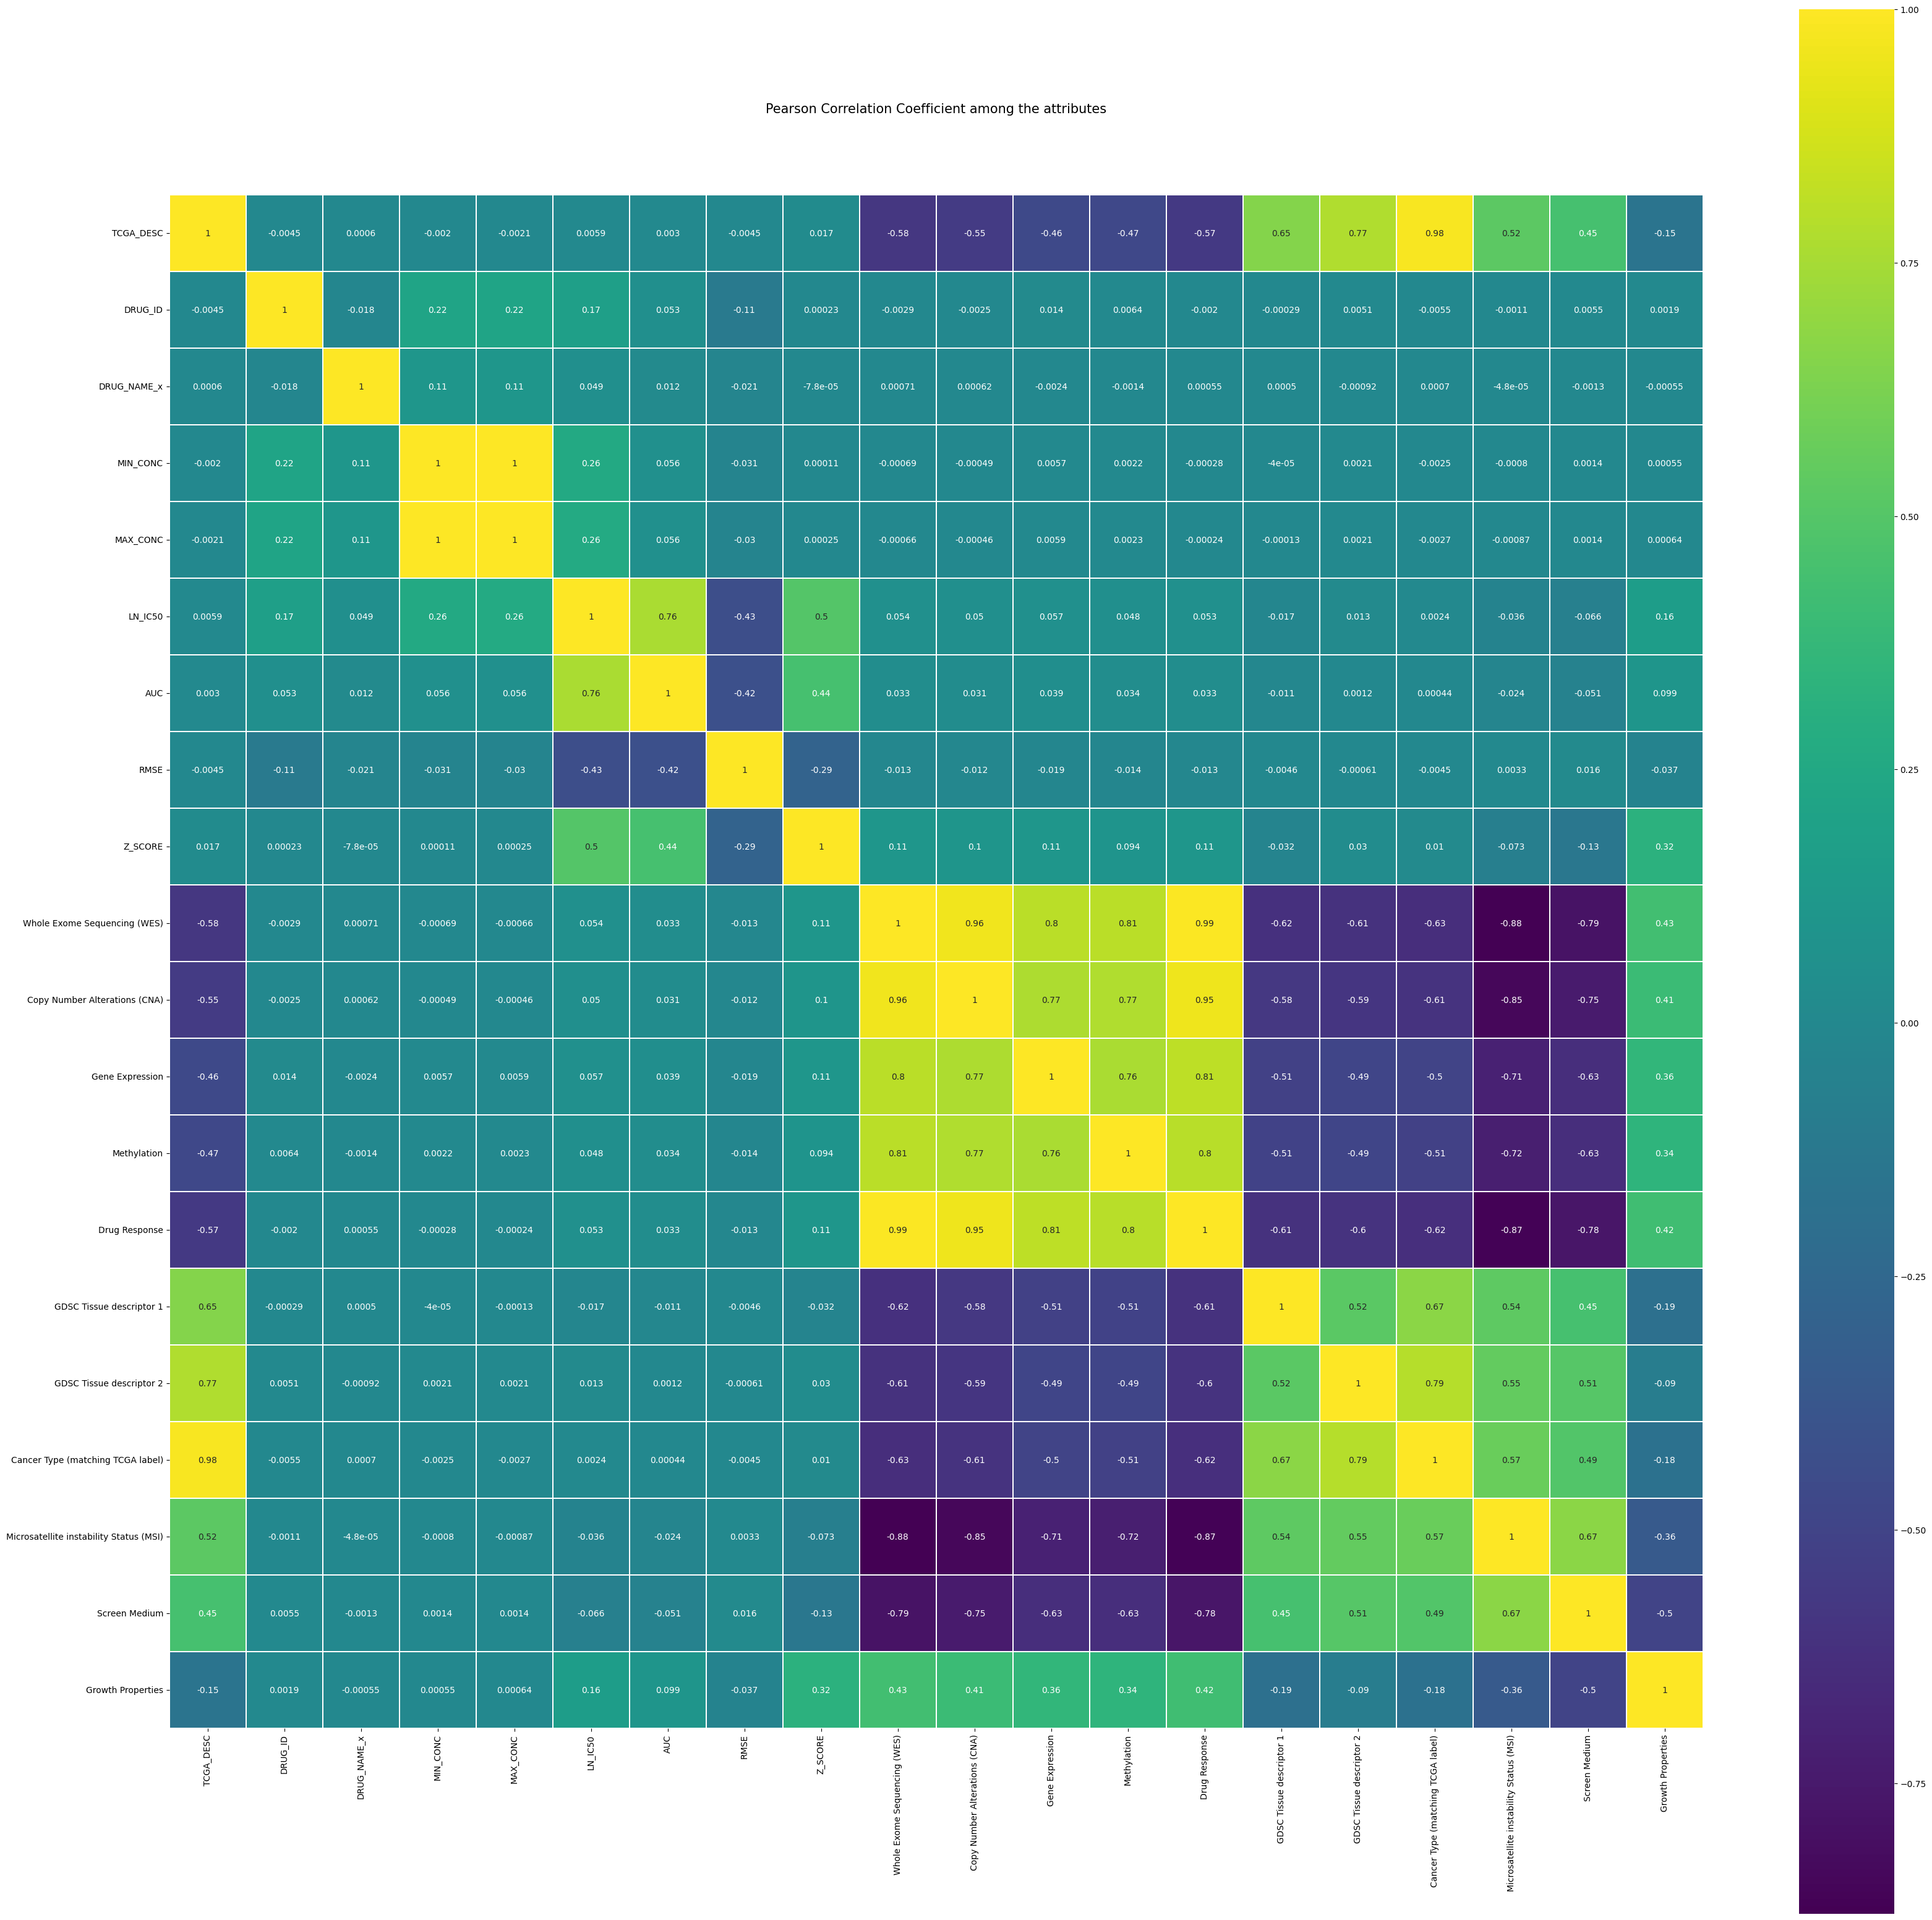

In [26]:
corr = dataset_corr.corr()
plt.figure(figsize=(40,40))
plt.title('Pearson Correlation Coefficient among the attributes', y=1.05, size=15)
sns.heatmap(corr,linewidths=0.1,vmax=1.0,
            square=True, cmap='viridis', linecolor='white', annot=True)
plt.savefig("datasetCorrelationMatrix.png", bbox_inches="tight")


We observe a strong correlation between Tissue Descriptor 1 and Tissue Descriptor 2 with the cancer type. This is expected, as these descriptors represent the tissue affected by cancer, which naturally varies depending on the cancer type.

A similar pattern appears across most of the cell line-related variables, such as gene expression, WES (Whole Exome Sequencing), and methylation profiles, all of which also show high correlation with cancer type due to their biological specificity.

Additionally, we find that LNIC_50 is highly correlated with both AUC and Z_score, which is logical considering that these metrics are often derived from or influenced by LNIC_50 itself. Therefore, these variables offer little additional value for predictive modeling and can be considered redundant in this context.

On the other hand, LNIC_50 does not exhibit strong correlation with most of the other features, which indicates that simple linear models may not be sufficient to capture the underlying relationships. This reinforces the need to apply deep learning techniques, as initially proposed, to uncover complex, non-linear patterns that could improve our ability to predict drug sensitivity.

# Defining the neural network

As a first step in preprocessing, we identify which variables in the dataset are still categorical. Since most machine learning and deep learning models require numerical input, it is essential to convert these categorical variables into a numerical format.

To achieve this, we apply one-hot encoding, a common technique that transforms each categorical feature into multiple binary (0/1) columns — one for each possible category. This ensures that the model can correctly interpret these variables without assuming any ordinal relationship between the categories.

Proper encoding of categorical variables is crucial to achieve optimal model performance and prevent biased or misleading results during training.

In addition to preprocessing the input features, we also separate the target variables from the dataset. While our primary target is LNIC_50, we also include AUC as a secondary target or auxiliary output to provide the model with additional information related to drug response.

Although AUC is partially derived from LNIC_50, including it can help the model capture complementary patterns in the data that may enhance generalization or improve convergence during training, especially when using deep learning architectures capable of multi-output learning or auxiliary loss functions.

This multi-target setup allows us to better exploit the relationships among related variables and potentially improve the model's understanding of drug sensitivity profiles.

In [27]:
print(dataset.select_dtypes(exclude="number").columns)

Index(['TCGA_DESC', 'DRUG_NAME_x', 'GDSC Tissue descriptor 1',
       'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
       'Microsatellite instability Status (MSI)', 'Screen Medium'],
      dtype='object')


This step represents a crucial part of the study. Initially, I spent considerable time training the network using LN_IC50 and AUC as target variables. However, after extensive reflection, I concluded that introducing categorical information might allow the model to learn more effectively or efficiently. Even though my primary interest remains in the LN_IC50 values, using extra data could guide the algorithm toward better performance.

In [28]:
# Define features and target variable
X = dataset.drop(columns=['LN_IC50', 'AUC', 'Z_SCORE', 'RMSE'])
y = dataset[['LN_IC50', 'AUC', 'Z_SCORE', 'RMSE']]

X = pd.get_dummies(X, columns=dataset.select_dtypes(exclude="number").columns).astype(float)

In [29]:
print(y.shape)

(213825, 4)


In [30]:
print(X.shape)
X.head()

(213825, 377)


,DRUG_ID,MIN_CONC,MAX_CONC,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug Response,Growth Properties,TCGA_DESC_ACC,...,Cancer Type (matching TCGA label)_SCLC,Cancer Type (matching TCGA label)_SKCM,Cancer Type (matching TCGA label)_STAD,Cancer Type (matching TCGA label)_THCA,Cancer Type (matching TCGA label)_UCEC,Cancer Type (matching TCGA label)_UNABLE TO CLASSIFY,Microsatellite instability Status (MSI)_MSI-H,Microsatellite instability Status (MSI)_MSS/MSI-L,Screen Medium_D/F12,Screen Medium_R
0,1003.0,0.0001,0.1,1.0,1.0,1.0,1.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1003.0,0.0001,0.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003.0,0.0001,0.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003.0,0.0001,0.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003.0,0.0001,0.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Find duplicated columns
duplicate_columns = X.columns[X.columns.duplicated()]
print("Duplicate columns:", duplicate_columns)

Duplicate columns: Index([], dtype='object')


In [32]:
# Remove duplicated columns
X = X.loc[:, ~X.columns.duplicated()]

In [33]:
feature_names = X.columns.tolist()

In [34]:
X = np.array(X)

### Dataset Splitting
Before training the model, we split the dataset into three subsets: training, validation, and test sets. This division is essential to ensure a reliable evaluation of model performance and to prevent overfitting.

- The training set is used to fit the model parameters.

- The validation set allows us to tune hyperparameters and monitor the model's performance during training by calculating the error on unseen data.

- Finally, the test set is used only after training is complete, to provide an unbiased estimate of the model's generalization ability on completely unseen data.

This strategy ensures that the model is not evaluated on data it has already seen during training or validation, thus preserving the integrity of the performance metrics.

In [35]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_ori, X_val_ori, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_ori)
X_val = scaler.transform(X_val_ori)
X_test = scaler.transform(X_test)

In [36]:
print(X_train.shape,X_test.shape, y_train.shape,y_test.shape)

(128295, 377) (42765, 377) (128295, 4) (42765, 4)


In [37]:
display(y_test.head())

,LN_IC50,AUC,Z_SCORE,RMSE
191360,0.759339,0.861553,-0.948095,0.078488
176657,4.168879,0.925970,0.874998,0.077342
129812,4.554145,0.983653,0.508327,0.095913
28144,4.533803,0.976061,-0.336717,0.060210
27485,2.226808,0.884830,-0.674964,0.134368


To train our model, we use [keras](https://keras.io), a high-level deep learning library that provides a wide range of pre-defined functions to facilitate the development and optimization of neural networks.

Additionally, we employ [PlotLossesKerasTF](https://pypi.org/project/livelossplot/) to obtain visual feedback during the training process. This is particularly valuable, as understanding how the model behaves during training can offer insights into potential improvements and adjustments.

In [38]:
from livelossplot import PlotLossesKerasTF

In [40]:
def generate_model(n_columns_x, n_columns_y):
    model = models.Sequential()
    model.add(layers.Input(shape=(n_columns_x,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(n_columns_y))
    return model
    
def represent_error_evolution(history, val_1="mse", val_2="val_mse"):
    plt.figure(1, figsize=(4,4))
    plt.plot(history.history[val_1])
    plt.plot(history.history[val_2])

    plt.yscale("log")
    plt.title('Model error')
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.grid()
    #plt.xlim(-0.5,20.1)
    plt.legend(['train', 'test'], loc='upper center')

    plt.savefig("MLP_OncoGenomicsDrugSensi_loss{}.jpg".format(str(datetime.datetime.now())))
    plt.show()

def represent_scatter_matrix(ax, y_test_df, predition_values, target_variable):

    ax.scatter(np.array(y_test_df[target_variable]), predition_values, s=2, alpha=0.5, color="black")
    ax.grid(True)

    ax.set_ylabel('Pronostics')
    ax.set_xlabel('Real')
    ax.set_title(target_variable)

def train_sequential_model(X_train, y_train, X_val, y_val, X_test, y_test, model: models.Sequential, optimizer="adam", error="mse"):
    model.compile(optimizer=optimizer, loss=error, metrics=[error])
    model.summary()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min',restore_best_weights=True)
    history=model.fit(X_train, y_train, 
                  epochs=100, 
                  batch_size=32, 
                  validation_data=(X_val, y_val), 
                  callbacks=[early_stopping, PlotLossesKerasTF()],
                  verbose=2)
    pred_test = model.predict(X_test)
    
    final_train_error = history.history['mse'][-1]
    final_val_error = history.history['val_mse'][-1]

    print(f"Error final en entrenamiento (MSE): {final_train_error}")
    print(f"Error final en validación (MSE): {final_val_error}")
    print(X_test.shape)
    print(y_test.shape)
    print(pred_test.shape)
    fig, axes = plt.subplots(2, 2, figsize=(8 * 1, 5 * 2))
    axes = axes.flatten()
    
    for i, target in enumerate(y_test.columns):
        represent_scatter_matrix(axes[i], y_test_df=y_test, predition_values=pred_test[:, i], target_variable=target)
        

    fig.tight_layout()
    plt.show()
    return model
    
    

In [41]:
print(X_test.shape)
print(y_test.shape)
print(y_test["LN_IC50"])

(42765, 377)
(42765, 4)
191360    0.759339
176657    4.168879
129812    4.554145
28144     4.533803
27485     2.226808
            ...   
153266    4.808403
2608      1.072319
1002     -3.113940
30495    -0.728229
168309    1.668381
Name: LN_IC50, Length: 42765, dtype: float64


In [42]:
model = generate_model(X_train.shape[1], y_test.shape[1])

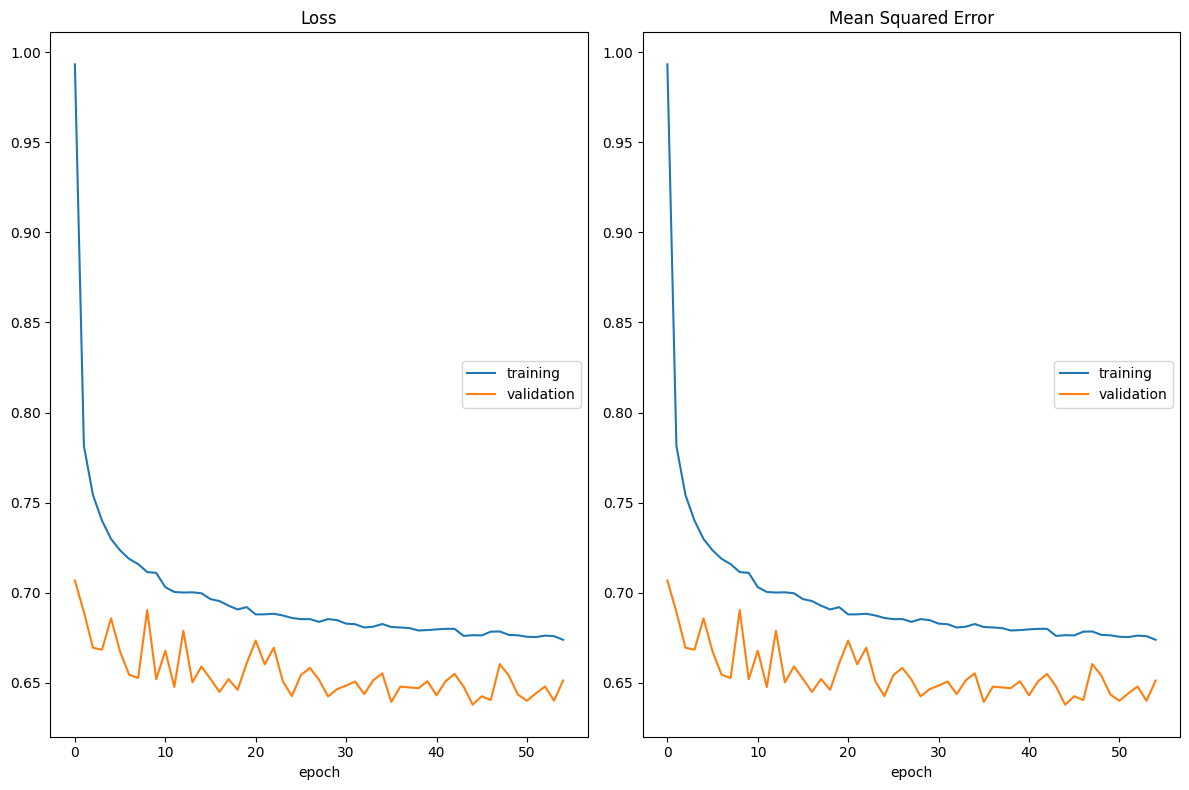

Loss
	training         	 (min:    0.674, max:    0.993, cur:    0.674)
	validation       	 (min:    0.638, max:    0.707, cur:    0.651)
Mean Squared Error
	training         	 (min:    0.674, max:    0.993, cur:    0.674)
	validation       	 (min:    0.638, max:    0.707, cur:    0.651)
4010/4010 - 3s - 783us/step - loss: 0.6740 - mse: 0.6740 - val_loss: 0.6514 - val_mse: 0.6514
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
Error final en entrenamiento (MSE): 0.6739640831947327
Error final en validación (MSE): 0.6513649225234985
(42765, 377)
(42765, 4)
(42765, 4)


IndexError: index 2 is out of bounds for axis 0 with size 2

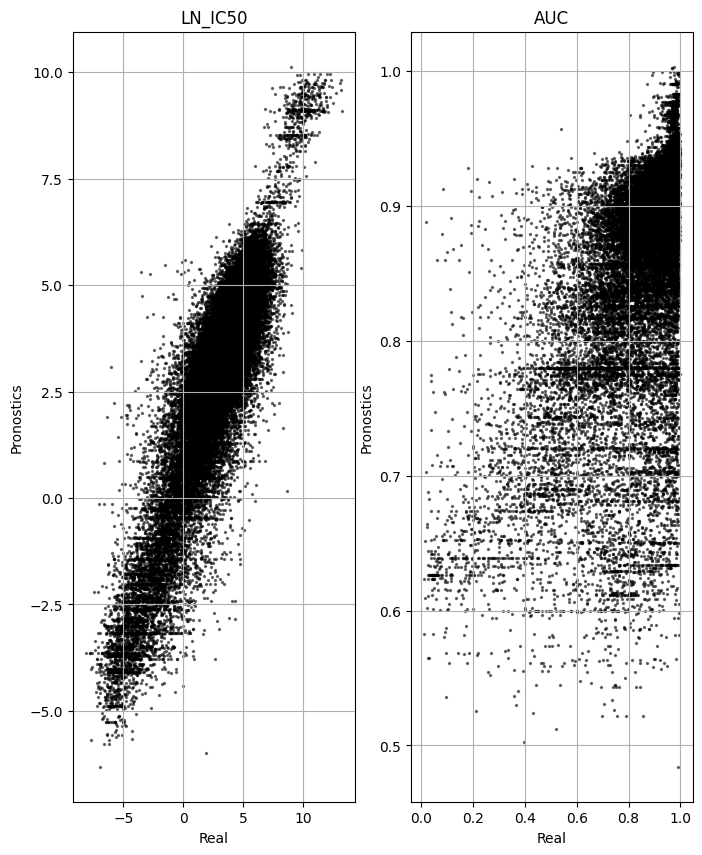

In [43]:
model = train_sequential_model(X_train, y_train, X_val, y_val, X_test, y_test, model)

## Representing the information

In [443]:
encoder = LabelEncoder()
X_tsne = dataset.copy().drop(columns=["LN_IC50", "AUC", "RMSE", "Z_SCORE"])
for col in X_tsne.select_dtypes(exclude=["number"]).columns:
    X_tsne[col] = encoder.fit_transform(X_tsne[col])

In [476]:
tsne_3d = TSNE(n_components=3, random_state=10, perplexity=40.0,init='random',learning_rate='auto')
X_3d = tsne_3d.fit_transform(X_tsne)

### Replacing the numerical problem by categorical problem

As the results obtained using the numerical target were not sufficiently satisfactory, we decided to replace it with a categorical target. This approach aims to reduce the complexity of the problem.

The first step in this process is to calculate the value ranges for categorization.

In [444]:
min_range_LN = dataset['LN_IC50'].min()
max_range_LN = dataset['LN_IC50'].max()
sum_min_max_LN = min_range_LN + max_range_LN

bins = pd.interval_range(start=min_range_LN, end=max_range_LN, periods=5)
labels_LN = [0, 1, 2, 3, 4]
bins = np.array([interval.left for interval in bins] + [bins[-1].right])

Next, we create a new column, `LN_IC50_Categorical`, which is derived from the original `LN_IC50` column by grouping its values into intervals.

In [446]:
# Create a new categorical column
y['LN_IC50_Categorical'] = np.digitize(dataset['LN_IC50'].astype(float), bins)

/var/folders/sl/6bh6kmv142759hyc6r3d8jqr0000gn/T/ipykernel_56129/1917380766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['LN_IC50_Categorical'] = np.digitize(dataset['LN_IC50'].astype(float), bins)


We can check the different values of the new column to be sure that we applied the transformation correctly.

In [447]:
print(y["LN_IC50_Categorical"].unique())
print(y["LN_IC50_Categorical"].shape)

[2 1 3 4 5 6]
(213825,)


We can display a data representation using the new column as target.

NameError: name 'X_3d' is not defined

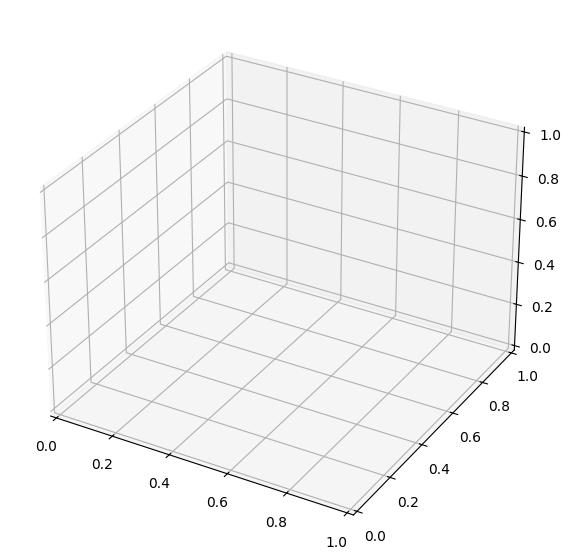

In [448]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y['LN_IC50_Categorical'].astype(int), cmap='viridis', alpha=0.8)
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)

plt.show()

import plotly.express as px

fig = px.scatter(dataset, x='LN_IC50', y='AUC', 
                 hover_data=['CELL_LINE_NAME', 'DRUG_NAME'],
                 title="Relación entre LN_IC50 y AUC",
                 labels={'LN_IC50': 'LN_IC50 (Sensibilidad al fármaco)', 'AUC': 'Área Bajo la Curva (Eficacia)'})

# Mostrar el gráfico interactivo

fig.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  
y_softmax = encoder.fit_transform(y["LN_IC50_Categorical"].values.reshape(-1, 1))

In [450]:
y_softmax.shape

(213825, 6)

In [472]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
scaler_cat = RobustScaler()
X_train_ori, X_test_ori, y_train, y_test = train_test_split(X, y_softmax, test_size=0.3, random_state=42)
X_train = scaler_cat.fit_transform(X_train_ori)
X_test = scaler_cat.transform(X_test_ori)
X_train_real, X_val, y_train_real, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [486]:
model = models.Sequential([
    Input(shape=X_train_real.shape[1:]),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(y_softmax.shape[1], activation='softmax')  # Capa de salida (Softmax para clasificación)
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Para clasificación multiclase
              metrics=['accuracy'])

history = model.fit(X_train_real, y_train_real, epochs=10, batch_size=16, validation_data=(X_val, y_val))
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en datos de prueba: {test_acc:.4f}")

Epoch 1/10
6549/6549 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7099 - loss: 0.7012 - val_accuracy: 0.7555 - val_loss: 0.5595
Epoch 2/10
6549/6549 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7540 - loss: 0.5533 - val_accuracy: 0.7604 - val_loss: 0.5446
Epoch 3/10
6549/6549 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7600 - loss: 0.5370 - val_accuracy: 0.7596 - val_loss: 0.5469
Epoch 4/10
6549/6549 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7680 - loss: 0.5207 - val_accuracy: 0.7606 - val_loss: 0.5406
Epoch 5/10
6549/6549 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7696 - loss: 0.5146 - val_accuracy: 0.7615 - val_loss: 0.5391
Epoch 6/10
6549/6549 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7726 - loss: 0.5096 - val_accuracy: 0.7641 - val_loss: 0.5412
Epoch 7/10
6549/6549 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.7751 - loss: 0.5022 - val_accuracy: 0.7587 - val_loss: 0.5561
Epoch 8/10
6549/6549 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7754 - loss: 0.4991 - 

<Axes: >

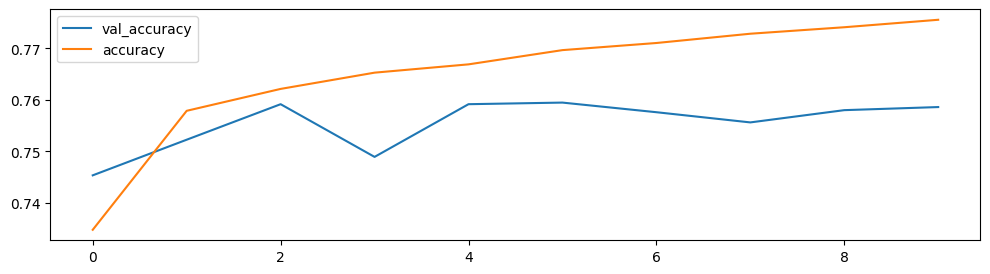

In [459]:
pd.DataFrame(history.history)[["val_accuracy", "accuracy"]].plot(figsize=(12,3))

In [59]:
model.evaluate(X_test, y_test)

2005/2005 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - accuracy: 0.7448 - loss: 0.6990


[0.7037919759750366, 0.7461027503013611]

In [497]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape

input_shape = (X_train_real.shape[1], 1)
inputs = Input(shape=input_shape)

# Capa convolucional + maxpool
x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D()(x)

# Capas densas
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Capa de salida (clasificación multiclase con softmax)
outputs = Dense(y_softmax.shape[1], activation='softmax')(x)

# Crear el modelo
model = Model(inputs=inputs, outputs=outputs)

In [498]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy, 
              metrics=["acc"])

In [499]:
history = model.fit(X_train_real, y_train_real, epochs=15, batch_size=32, validation_data=(X_val, y_val))
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/15
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - acc: 0.6970 - loss: 0.7416 - val_acc: 0.7510 - val_loss: 0.5704
Epoch 2/15
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - acc: 0.7557 - loss: 0.5630 - val_acc: 0.7553 - val_loss: 0.5592
Epoch 3/15
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - acc: 0.7552 - loss: 0.5547 - val_acc: 0.7568 - val_loss: 0.5534
Epoch 4/15
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - acc: 0.7576 - loss: 0.5484 - val_acc: 0.7573 - val_loss: 0.5505
Epoch 5/15
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - acc: 0.7621 - loss: 0.5396 - val_acc: 0.7596 - val_loss: 0.5479
Epoch 6/15
 547/3275 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - acc: 0.7586 - loss: 0.5355

KeyboardInterrupt: 

# Defining the XGBOOST

Since now, with the purpouse of get a better result we are going to try the 

In [500]:
import xgboost as xgb

y.loc[:, "LN_IC50_Categorical_xgb"] = y["LN_IC50_Categorical"] - 1


/var/folders/sl/6bh6kmv142759hyc6r3d8jqr0000gn/T/ipykernel_56129/426843429.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, "LN_IC50_Categorical_xgb"] = y["LN_IC50_Categorical"] - 1


In [501]:
num_classes = y["LN_IC50_Categorical_xgb"].unique().size
y["LN_IC50_Categorical_xgb"].unique()

array([1, 0, 2, 3, 4, 5])

In [502]:
scaler_cat = RobustScaler()
X_train_ori, X_test_ori, y_train, y_test = train_test_split(X, y["LN_IC50_Categorical_xgb"], test_size=0.3, random_state=42)
X_train = scaler_cat.fit_transform(X_train_ori)
X_test = scaler_cat.transform(X_test_ori)
X_train_real, X_val, y_train_real, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [504]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [505]:
params = {
    "objective": "multi:softmax",  # Usa "multi:softprob" si quieres probabilidades
    "num_class": num_classes,
    "eval_metric": "mlogloss"
}
evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [506]:
num_round = 1000
bst = xgb.train(params, dtrain, num_round, evallist)

/Users/sergiosantiago/developments/master/TFM/venv/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.42580	eval-mlogloss:1.42624
[1]	train-mlogloss:1.20844	eval-mlogloss:1.20891
[2]	train-mlogloss:1.07445	eval-mlogloss:1.07518
[3]	train-mlogloss:0.97926	eval-mlogloss:0.97995
[4]	train-mlogloss:0.90918	eval-mlogloss:0.91030
[5]	train-mlogloss:0.85599	eval-mlogloss:0.85734
[6]	train-mlogloss:0.81543	eval-mlogloss:0.81718
[7]	train-mlogloss:0.78336	eval-mlogloss:0.78541
[8]	train-mlogloss:0.75685	eval-mlogloss:0.75940
[9]	train-mlogloss:0.73487	eval-mlogloss:0.73722
[10]	train-mlogloss:0.71727	eval-mlogloss:0.72003
[11]	train-mlogloss:0.70258	eval-mlogloss:0.70563
[12]	train-mlogloss:0.69002	eval-mlogloss:0.69340
[13]	train-mlogloss:0.67830	eval-mlogloss:0.68185
[14]	train-mlogloss:0.66841	eval-mlogloss:0.67219
[15]	train-mlogloss:0.65912	eval-mlogloss:0.66338
[16]	train-mlogloss:0.65231	eval-mlogloss:0.65671
[17]	train-mlogloss:0.64618	eval-mlogloss:0.65082
[18]	train-mlogloss:0.64011	eval-mlogloss:0.64506
[19]	train-mlogloss:0.63513	eval-mlogloss:0.64043
[20]	train

In [507]:
y_pred = bst.predict(dtest)

In [516]:
df_comparacion = pd.DataFrame({
    "Valor Real": y_test,
    "Valor Predicho": y_pred,
    "Error Absoluto": abs(pd.Series(y_test) - pd.Series(y_pred))  # Error absoluto
})
display(df_comparacion)
print(np.isnan(y_pred).sum())
print(y_pred)

ValueError: array length 64148 does not match index length 109227

In [509]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7680208268379373


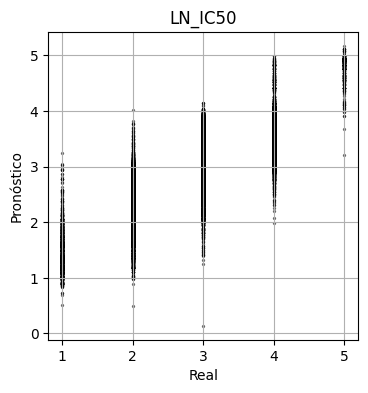

In [810]:
plt.figure(1, figsize=(4,4))

plt.scatter(y_test, y_pred, s=2, alpha=0.5, color="black")
plt.grid()

#plt.plot([5,50],[5,50])
plt.ylabel('Pronóstico')
plt.xlabel('Real')
plt.title('LN_IC50')

plt.savefig("images/XGBOOST/MLP_XGBOOST_LN_IC50_TruePred.jpg")
plt.savefig(f"images/logs/XGBOOST/MLP_XGBOOST_LN_IC50_TruePred{datetime.datetime.now().timestamp()}.jpg")
plt.show()

In [1266]:
rmse = root_mean_squared_error(y_test["LN_IC50"], y_pred)
print(f"RMSE: {rmse}")

# R²
r2 = r2_score(y_test["LN_IC50"], y_pred)
print(f"R²: {r2}")

RMSE: 1.4130413443996155
R²: 0.7525650361020353


# Random forest

In [880]:
from sklearn.ensemble import RandomForestClassifier

randonForest = RandomForestClassifier(max_depth=120)

randonForest.fit(X_train, y_train)

: 

In [881]:
randonForest.score(X_test, y_test)

0.7516680177090478

In [877]:
depths = [estimator.tree_.max_depth for estimator in randonForest.estimators_]

print(f"Dataset has {X_train.shape[1]}")
print(f"Max depth: {max(depths)}")

Dataset has 401
Max depth: 218


## Shap Algorithm

In [83]:
import shap

/Users/sergiosantiago/developments/master/TFM/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [161]:
shap.initjs()


In [84]:
print(X_train.shape)
X_train = np.squeeze(X_train)
print(X_train.shape)
print(type(X_train))

(149677, 401)
(149677, 401)
<class 'numpy.ndarray'>


In [146]:
n_events= 50 # mejor usar 100, he ejecutado con 200 pero más lento

In [147]:
# Este funcional
explainer_XAI = shap.KernelExplainer(model, X_train[0:n_events])
# Este también funciona
#explainer_XAI = shap.GradientExplainer(model,train_data[0:n_events])

In [148]:
# El resultado es una lista que incluye un solo array en su interior, por eso siempre pongo shap_values[0]
shap_values = explainer_XAI.shap_values(X_train[0:n_events])
print(type(shap_values))

100%|██████████| 50/50 [04:03<00:00,  4.88s/it]

<class 'numpy.ndarray'>


In [172]:
print(shap_values.shape)
shap_values=np.squeeze(shap_values)
print(shap_values.shape)
print(X_train[:n_events].shape)

(50, 401, 6)
(50, 401, 6)
(50, 401)


In [184]:
print(shap_values[:][:][:].shape)

(50, 401, 6)


In [179]:
for i in range(6):  # Para cada clase
    print(f"Clase {i} - SHAP Values shape:", shap_values[i].shape)
    print(shap_values[i].shape[0] == X_train[:n_events].shape[0])

print("X_train shape:", X_train[:n_events].shape)


Clase 0 - SHAP Values shape: (401, 6)
False
Clase 1 - SHAP Values shape: (401, 6)
False
Clase 2 - SHAP Values shape: (401, 6)
False
Clase 3 - SHAP Values shape: (401, 6)
False
Clase 4 - SHAP Values shape: (401, 6)
False
Clase 5 - SHAP Values shape: (401, 6)
False
X_train shape: (50, 401)


In [186]:
print(feature_names)


['DRUG_ID', 'MIN_CONC', 'MAX_CONC', 'Whole Exome Sequencing (WES)', 'Copy Number Alterations (CNA)', 'Gene Expression', 'Methylation', 'Drug Response', 'Growth Properties', 'TCGA_DESC_ACC', 'TCGA_DESC_ALL', 'TCGA_DESC_BLCA', 'TCGA_DESC_BRCA', 'TCGA_DESC_CESC', 'TCGA_DESC_CLL', 'TCGA_DESC_COREAD', 'TCGA_DESC_DLBC', 'TCGA_DESC_ESCA', 'TCGA_DESC_GBM', 'TCGA_DESC_HNSC', 'TCGA_DESC_KIRC', 'TCGA_DESC_LAML', 'TCGA_DESC_LCML', 'TCGA_DESC_LGG', 'TCGA_DESC_LIHC', 'TCGA_DESC_LUAD', 'TCGA_DESC_LUSC', 'TCGA_DESC_MB', 'TCGA_DESC_MESO', 'TCGA_DESC_MM', 'TCGA_DESC_NB', 'TCGA_DESC_OTHER', 'TCGA_DESC_OV', 'TCGA_DESC_PAAD', 'TCGA_DESC_PRAD', 'TCGA_DESC_SCLC', 'TCGA_DESC_SKCM', 'TCGA_DESC_STAD', 'TCGA_DESC_THCA', 'TCGA_DESC_UCEC', 'TCGA_DESC_UNCLASSIFIED', 'DRUG_NAME_x_5-Fluorouracil', 'DRUG_NAME_x_5-azacytidine', 'DRUG_NAME_x_A-366', 'DRUG_NAME_x_ABT737', 'DRUG_NAME_x_AGI-5198', 'DRUG_NAME_x_AGI-6780', 'DRUG_NAME_x_AGK2', 'DRUG_NAME_x_AMG-319', 'DRUG_NAME_x_AT13148', 'DRUG_NAME_x_AZ6102', 'DRUG_NAME_x_AZ

In [196]:
shap.force_plot(explainer_XAI.expected_value[0], shap_values[..., 0], X_train[:n_events], feature_names=feature_names)

In [1]:
shap.plots.bar(shap_values)

NameError: name 'shap' is not defined

<Figure size 600x600 with 0 Axes>

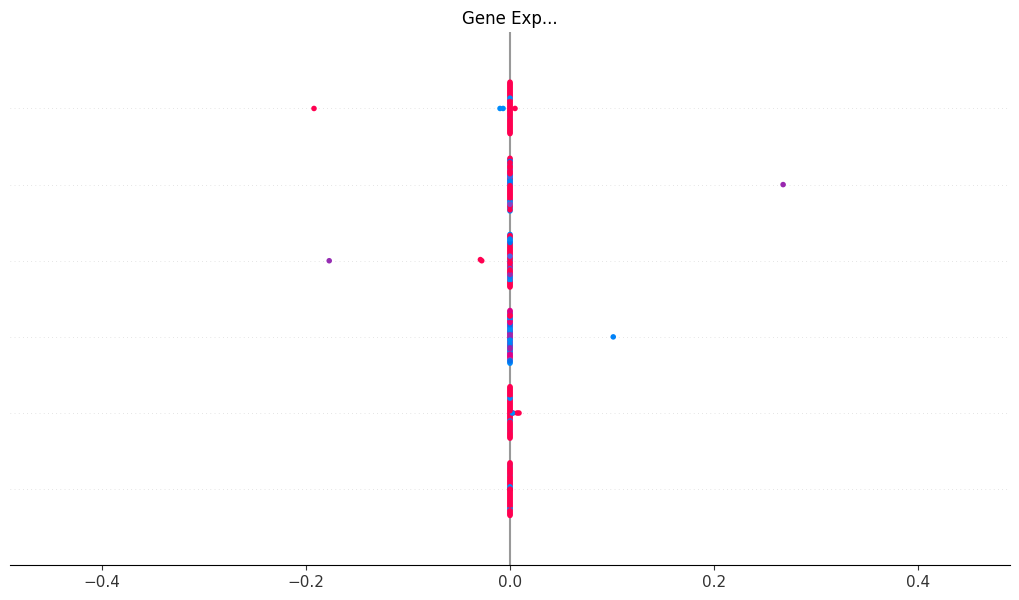

In [194]:
plt.figure(1, figsize=(6,6))
plt.subplots_adjust(wspace=1, hspace=0.5,left=0.20,right=0.95,top=0.90,bottom=0.10)
shap.summary_plot(shap_values, X_train[0:n_events], 
                  feature_names=feature_names,
                  max_display = 6, show=True)
#plt.savefig('ShapSummaryPlot_OncoGemomicsDrugsSensitivity_MLP_'+str(n_events)+
#            '_n_columns_'+str(len(columns_names))+
#            '.jpg')

In [138]:
print(shap_values[0].shape)
print(X_train[0].shape)
print(type(shap_values[0]))
print(type(X_train[0]))

(401, 6)
(401,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [52]:
# Explainability of the event of trainingset of index the value idx.
idx=50

print(", con etiqueta: ",y_train[idx], pred_X_train[idx])

def myexplanation(shap_values, idx):
    my_exp = shap.Explanation(
    values =  shap_values[idx],
    data = X_train[idx],
    feature_names = feature_names,
    #base_values = explainer_M3XAI.expected_value[0] # este también funciona
    base_values = explainer_XAI.expected_value.mean()
    )
    return my_exp

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

plt.subplots_adjust(top = 0.9, left=0.40, right=0.91, bottom = 0.12)
fig.text(0.2, 0.9, "Y: "+str(np.round(y_train[idx],2))+
         ', predicted: ' +str(np.round(pred_X_train[idx],2)), fontsize=12)

shap.plots.waterfall( myexplanation(shap_values, idx), max_display = 12, show=False)

plt.savefig('ShapWaterFallPlot_event_OncoGemomicsDrugsSensitivity_MLP_'+str(idx)+
            '_n_columns_'+str(len(feature_names))+
            '.jpg')

KeyError: 50